Animesh Guchhait

MDS202004

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Important libraries
from tqdm import tqdm
import json
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk . probability import FreqDist
import pandas as pd
import numpy as np
nltk.download('stopwords')
from nltk . corpus import stopwords
import re
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import os
from copy import deepcopy
from collections import defaultdict
import math
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Unzip the provided zip data in the colab disk 

In [ ]:
!cp /content/drive/MyDrive/NLP/pdf_json.zip pdf_json.zip
!unzip -oq pdf_json.zip
print('Unzip Completed')

Unzip Completed


In [ ]:

def extract_text(filename):
    '''
    Extract the text from the file name (json file) and
    index the content from paper_id, title, abstract and body_text fields
    Retuns - text of title, abstract and bodt_text
    '''

    file = open(filename)
    body_text = ""
    abstract = ""
    title = ""
    paper_id = ""

    paper_content = json.load(file)

    #get the paper_id
    if 'paper_id' in paper_content:
        paper_id = paper_content['paper_id']
        
    #get the title, if available
    if 'title' in paper_content['metadata']:
        title = paper_content['metadata']['title']
    #get abstract.text, if available
    if 'abstract' in paper_content:
        for abs in paper_content['abstract']:
            abstract = abstract + abs['text']
    if 'body_text' in paper_content:
        for bt in paper_content['body_text']:
            body_text = body_text + bt['text']


   
    return (title + ' ' + abstract + ' ' + body_text + ' ').lower()



In [ ]:
#split the text and removes non alphaneumeric characters using regex

def split_and_re_alphaneumeric(words):
  words=words.split()
  for i in range(len(words)):
    words[i]=re.sub('[\W\_]','',words[i])
    
  return words
  

In [ ]:
# Remove stop words, '' and neumeric
def remove_sw(words):
    stop_words = set(stopwords.words('english'))
    return [i for i in words if i not in stop_words and i not in [''] and  i.isalpha()]

In [ ]:
'''steps
    1.  lemmantizer on noun
    2.  lemmantizer on adjective
    3.  proter stemmer on all words
    4.  lemmantizer on verb'''


def  lemmatization(words):
  lemmatizer = WordNetLemmatizer()
  ps =PorterStemmer()
  for i in range(len(words)):

    w=words[i]

    rootWord=lemmatizer.lemmatize(w,pos='n')

    rootWord=lemmatizer.lemmatize(rootWord,pos='a')

    rootWord=ps.stem(rootWord)
   
    words[i]=lemmatizer.lemmatize(rootWord,pos='v')
  return words




In [ ]:
''' Here using this file_formating function , by giving a folder location and json filenames present in 
that folder, we can get extracted files(using extract_text function in this function) as elements of a list
i.e. the first element of the list will be text file which contain the text of the first json file name (like that)'''


def file_formatting(filenames,path):
    fnames =deepcopy(filenames)
    files = []
    c=0
    for filename in fnames:
        #if c>= 3000:
         # break
        try:
            file=extract_text(path+'/'+filename)
            files.append(file)
           # c=c+1
        except:
            ind = filenames.index(filename)
            #print('hoche na')
            filenames.pop(ind)
    return files

In [ ]:
# getting path and file name of our pdf_json folder where we unzip our given data
path='/content/pdf_json'
filenames = os.listdir(path)


In [ ]:
files=file_formatting(filenames,path)  # Called the file-formating function to get extracted text documents as elements of a list

In [ ]:
len(files)

56528

In [ ]:
'''All the preprocessing task are done here in steps to all the text files
   step:
   1.  split and re_alphaneumeric : to split the text and removes non alphaneumeric characters
   2. remove_sw : to remove stop words, '' and neumeric
   3. lemmatization: for lemmatization and stemming operations
   4. then save it to another list and delete the previous unpreprocessed file '''


file_store=[]
for i in tqdm(range(len(files))):            
  words=split_and_re_alphaneumeric(files[0])
  words=remove_sw(words)
  words=lemmatization(words)
  file_store.append(words)
  del words
  del files[0]



100%|██████████| 56528/56528 [1:28:51<00:00, 10.60it/s]


In [ ]:
del files

In [ ]:
# By this code I have write the preprocessed documents in text files and have zip those files and saved that for future use.

os.mkdir('/content/preproc/')
for i in range(len(file_store)):
  with open('/content/preproc/'+filenames[i][:-5]+'.txt','w') as f:
    f.write(' ' .join(file_store[i]))
!zip -r preproc.zip /content/preproc/
!cp preproc.zip /content/drive/MyDrive/NLP

This link is for the preprocesed documents :

https://drive.google.com/file/d/1UlbaqkCnobqgWbHFhz2GhcmAs8oXPOlm/view?usp=sharing

I have already saved the preprocessed files for fututre use. Now for the next part of this assignment, I have unzip the preprocessed file here in colab disk in the very next step and have performed remaining part of the assignment.

In [ ]:
!cp /content/drive/MyDrive/NLP/preproc.zip preproc.zip
!unzip -q preproc.zip
print('Unzip Completed')

Unzip Completed


In [ ]:
path='/content/content/preproc'  # getting path and file name of our preprocessed files 
filenames = os.listdir(path)

In [ ]:
'''Given the filenames, this function will go through each file and 
   1. will count total number of words/token and will store it in count
   2. will count the frequency of each word/token and will create a matrix for that named d
   3. will also count total number of vocabulary for each 10,000 words count done and  will store that on list named l '''

def frequency_matrix(filenames):
  d = defaultdict(int)
  count=0  
  l=[]
  for i in tqdm(range(len(filenames))):
    with open('/content/content/preproc/'+filenames[i],'r') as f:   # Reading each file
      t=f.read().split()
    for j in t:
      d[j]=d[j]+1
      count=count+1
      if count % 10000 ==0:                        # For each 10,000 words, count total number of vocabulary
        l.append([len(d.keys()),count])
    del t

  #for i in d.keys():
    #d[i]=d[i]/count
  d=dict(d)
  d=pd.DataFrame(d.values(),d.keys())
  d.columns=['frequency']
  d=d.sort_values("frequency", axis = 0, ascending = False)    # sorting the word frequency matrix according to the frequency 
  return(d,count,l)


In [ ]:
d,count,l=frequency_matrix(filenames)

100%|██████████| 56528/56528 [01:05<00:00, 859.01it/s]


In [ ]:
count  # Total number of tokens/words

130954034

In [ ]:
l[:5]   # This list showing total number of vocabulary after each 10,000 tokens are counted.

[[2485, 10000], [3798, 20000], [4709, 30000], [5538, 40000], [6529, 50000]]

In [ ]:
d[:30000].index  # First 30,000 most frequence words
# you can see that for lemmatization and stemming some words are destorted. like, study becomes studi.

Index(['use', 'patient', 'cell', 'infect', 'studi', 'et', 'al', 'viru', 'also',
       'may',
       ...
       'arna', 'autocrat', 'particlesml', 'patellar', 'carey', 'pector',
       'candesartan', 'hbot', 'kranken', 'snrnp'],
      dtype='object', length=30000)

In [ ]:
# Creating the rank of each token by just using rank = index+1
d['word']=d.index
d=d.reset_index()
d['rank']=d.index + 1


In [ ]:
# But using the above ranking method we are giving diffrent rank to the same frequency words according to their indexing.
# Now here I have fixed that thing by giving them same rank 
''' Suppose our frequency matrix is
           covid     2345
           use       1545
           patient    1545
           infect     1234
           
      Then rank will be 
          covid    1
          use      2
          patient  2
          infect   4'''

fre=list(d['frequency'])
rank=list(d['rank'])
t=fre[0]
for i in tqdm(range(1,len(fre))):
  s=fre[i]
  if s==t:
    rank[i]=rank[i-1]
  t=s



100%|██████████| 1749208/1749208 [00:00<00:00, 1793858.32it/s]


In [ ]:
d['rank']=rank

In [ ]:
d

,index,frequency,word,rank
0,use,963794,use,1
1,patient,883545,patient,2
2,cell,741721,cell,3
3,infect,697708,infect,4
4,studi,695967,studi,5
...,...,...,...,...
1749204,functionangiogenesi,1,functionangiogenesi,658779
1749205,httppedneuroaiimsorgdevelopmentalstimulationhtml,1,httppedneuroaiimsorgdevelopmentalstimulationhtml,658779
1749206,httppedneuroaiimsorgdomiciliarymanagementofacu...,1,httppedneuroaiimsorgdomiciliarymanagementofacu...,658779
1749207,hypsarrythmia,1,hypsarrythmia,658779


Zipf's Law

$f(r) ∝ \frac{1}{r^α} $

$f(r) = k \frac{1}{r^α} $

k=f(r) for r=1

$a ln(r)=ln(k)-ln(f(r))$

$a =\frac{ln(k)-ln(f(r))}{ln(r)}$




In [ ]:
''' Given d, it will compute alpha for every word with rank >1 and
 will return average of those alpha and a data frame showing alpha for each tokens'''

 
def find_alpha(d):
  k=d.loc[0,'frequency']
  d=d[d['rank']>1]
  d['alpha']=(np.log(k)-np.log(d['frequency']))/np.log(d['rank'])
  return(d,d['alpha'].mean())


In [ ]:
d1,alpha=find_alpha(d)

In [ ]:
d1

,index,frequency,word,rank,alpha
1,patient,883545,patient,2,0.125421
2,cell,741721,cell,3,0.238396
3,infect,697708,infect,4,0.233051
4,studi,695967,studi,5,0.202291
5,et,609624,et,6,0.255634
...,...,...,...,...,...
1749204,transmissionpeopl,1,transmissionpeopl,658779,1.028399
1749205,sourcetransmiss,1,sourcetransmiss,658779,1.028399
1749206,sxiedllf,1,sxiedllf,658779,1.028399
1749207,ectodomainbas,1,ectodomainbas,658779,1.028399


In [ ]:
del d1

In [ ]:
alpha           # The value of alpha for this data

1.0075247330739372

Heaps' Law

$M = K T^b $

$ log(M)=log(K) + b log(T)$


In [ ]:
data=pd.DataFrame(l)   # l is coming from frequency_matrix function , This list l showing total number of vocabulary after each 10,000 tokens are counted.

In [ ]:
data.columns=['M','T']

In [ ]:
data

,M,T
0,2031,10000
1,3710,20000
2,4759,30000
3,5793,40000
4,6947,50000
...,...,...
13090,1748786,130910000
13091,1748865,130920000
13092,1748992,130930000
13093,1749062,130940000


In [ ]:
# Changing values to log scale
data['M']=np.log(data['M'])   
data['T']=np.log(data['T'])

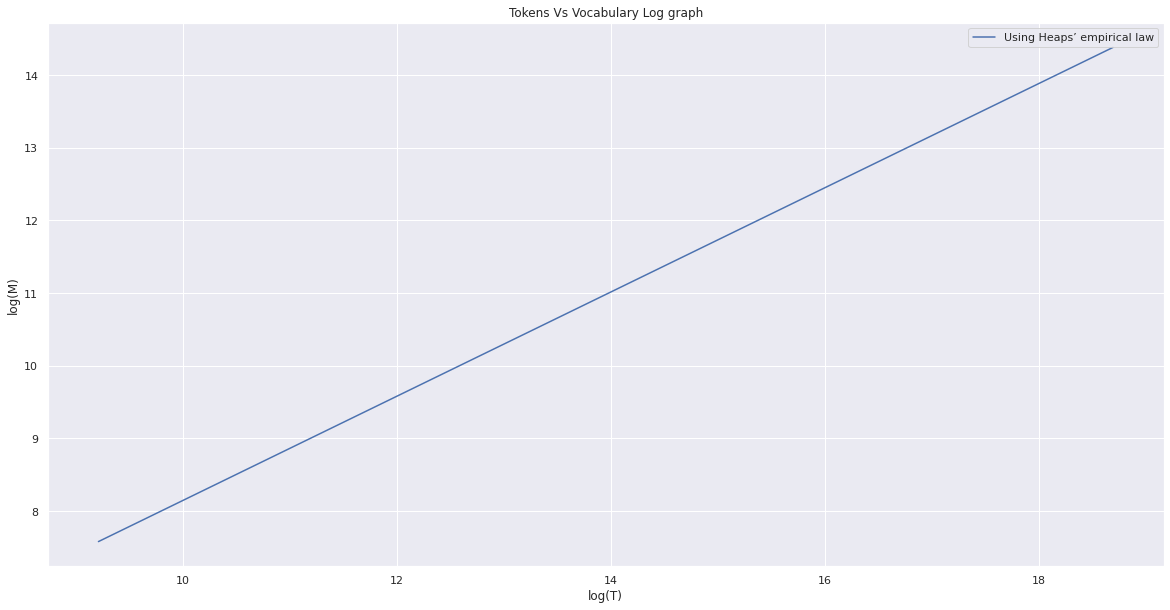

In [ ]:
# To plot token vs vocabulary log graph

sns.set(rc={'figure.figsize':(20,10)})
#obtain m (slope) and b(intercept) of linear regression line
b,m = np.polyfit(data['T'],data['M'], 1)

#add linear regression line to scatterplot 
plt.plot(data['T'], b*data['T']+m,label='Using Heaps’ empirical law')

plt.legend()
plt.title('Tokens Vs Vocabulary Log graph')
plt.xlabel('log(T)')
plt.ylabel('log(M)')
plt.show()

In [ ]:
m,b # m (slope) and b(intercept) of linear regression line

(0.9762517384787793, 0.7171494201512824)

In [ ]:
math.exp(m)

2.654487856850796

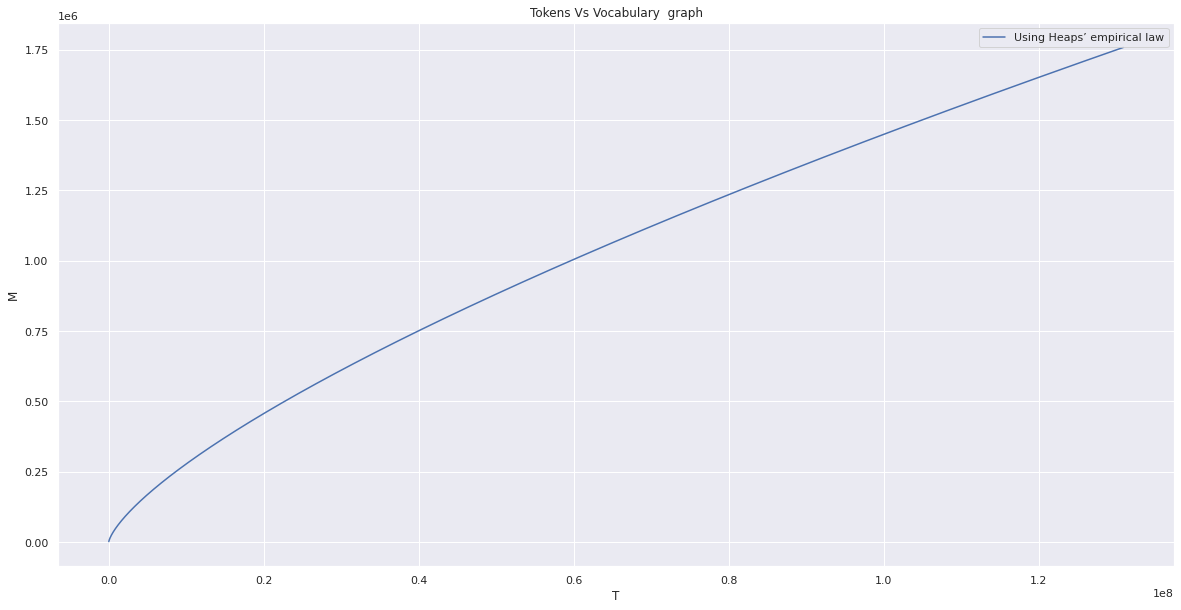

In [ ]:
# To plot token vs vocabulary graph

sns.set(rc={'figure.figsize':(20,10)})

plt.plot(np.exp(data['T']), math.exp(m)*np.exp(data['T'])**b,label='Using Heaps’ empirical law')

plt.legend()
plt.title('Tokens Vs Vocabulary  graph')
plt.xlabel('T')
plt.ylabel('M')
plt.show()